In [1]:
import pandas as pd
import numpy as np
import tarfile
import io
import glob
import dask.dataframe as dd

# import xgboost as xgb
# from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

import lightgbm as lgb
import warnings
warnings.simplefilter("ignore")



tar = tarfile.open('../data/raw/20181120_track_features.tar.gz', 'r:gz')
csv_files = tar.getnames()

tf_df_list = []

for csv_file in [csv_files[2], csv_files[4]]:
    csv_contents = tar.extractfile(csv_file).read()
    tf_df_list.append(pd.read_csv(io.BytesIO(csv_contents), encoding='utf8'))

tf_df = pd.concat(tf_df_list, ignore_index=True)
tf_df.rename(columns={'track_id':'track_id_clean'}, inplace=True)

kmean300_df = pd.read_csv('../data/interim/all_data/mbKMeans300clusters.csv', usecols=['track_id','clus'])
kmean300_df.rename(columns={'track_id':'track_id_clean'}, inplace=True)



In [2]:
def get_sim(df_hist, df_lookup, sim_file_list, score_name_list):
    df_hist['ListenYes'] = (df_hist['skip_2'] == False)*1
    df_hist['ListenYes'].replace(0, -1, inplace = True)
    df_hist = df_hist.groupby(['session_id', 'clus']).agg({'ListenYes':['sum']})
    df_hist = df_hist.reset_index()
    df_hist.columns = df_hist.columns.droplevel(level = 1) # take out the unwanted level
    df_pivot = pd.pivot_table(df_hist, values = 'ListenYes',index='session_id', columns='clus')
    df_pivot = df_pivot.fillna(0)
    
    
    for sim_file, score_name in zip(sim_file_list, score_name_list):
        sim_matrix = pd.read_csv(sim_file).drop(columns=['Unnamed: 0'])
        sim_matrix.columns = list(map(str, range(0,len(sim_matrix))))
        df_sim_session = df_pivot.dot(sim_matrix)/sim_matrix.sum()
        
        df_lookup[score_name] = df_sim_session.lookup(df_lookup['session_id'],df_lookup['clus'].astype(str))
    
    return df_lookup

In [3]:
file_list = glob.glob('../data/raw/training_set/log_9*.csv')
import random
random.Random(23).shuffle(file_list) # randomly shuffle the list

In [4]:
def prep_dfs_eval(file, tf_df):
    log_df = pd.read_csv(file)
    log_df = log_df.merge(kmean300_df)

    log_df_1 = log_df.loc[log_df['session_position']<=(log_df['session_length']/2)]
    log_df_1['hour_of_day'] = log_df_1['hour_of_day'].astype('float')
    log_df_1['premium'] = log_df_1['premium'].astype('bool')
    log_df_1['weekday'] = log_df_1['date'].astype('datetime64[ns]').dt.dayofweek
    log_df_1 = log_df_1.drop(columns = ['date'])
    log_df_1 = pd.get_dummies(log_df_1, columns=['hist_user_behavior_reason_end', 'hist_user_behavior_reason_start', 'context_type','weekday'], dtype = 'bool')
    log_df_1 = log_df_1.merge(tf_df.drop(columns = ['time_signature','mode','key']))
    
                     
    col_bool = log_df_1.columns[log_df_1.dtypes=='bool']
    col_nonbool = log_df_1.columns[log_df_1.dtypes!='bool'].drop(['session_id','track_id_clean','clus'])
    
    # the non-convertable values will be set to 0
    log_df_1[col_nonbool] = log_df_1[col_nonbool].apply(pd.to_numeric, errors='coerce', downcast = 'float').fillna(0).astype('float32')

    # aggregate the track history where ['skip_2']==True
    log_df_1_summary_skip2True = pd.concat([log_df_1.loc[log_df_1['skip_2']==True].groupby(['session_id'])[col_bool].agg(['mean']), 
                                            log_df_1.loc[log_df_1['skip_2']==True].groupby(['session_id'])[col_nonbool].agg(['mean', 'std', 'median'])],
                                            axis = 1)
    log_df_1_summary_skip2True.columns = log_df_1_summary_skip2True.columns.get_level_values(0)+'_sk2True_'+log_df_1_summary_skip2True.columns.get_level_values(1)
    
    # aggregate the track history where ['skip_2']==False
    log_df_1_summary_skip2False = pd.concat([log_df_1.loc[log_df_1['skip_2']==False].groupby(['session_id'])[col_bool].agg(['mean']), 
                                             log_df_1.loc[log_df_1['skip_2']==False].groupby(['session_id'])[col_nonbool].agg(['mean', 'std', 'median'])],
                                             axis = 1)
    log_df_1_summary_skip2False.columns = log_df_1_summary_skip2False.columns.get_level_values(0)+'_sk2False_'+log_df_1_summary_skip2False.columns.get_level_values(1)
    
    
    log_df_history = log_df_1[['session_id','track_id_clean','skip_2','clus']]


    half_cut = log_df['session_length']/2

    # need to at least include 2 trials, otherwise the log_df_1_summary will confound with all the tracks in the same session

#     #1st trial in the 2nd half
#     log_df_2_1 = log_df.loc[(log_df['session_position']>half_cut) & (log_df['session_position']<=half_cut+1)]
#     log_df_2_1 = log_df_2_1[['session_id','track_id_clean','skip_2','session_position','session_length','clus']]
#     log_df_2_1['weight'] = 1

#     #2nd trial in the 2nd half
#     log_df_2_2 = log_df.loc[(log_df['session_position']>half_cut+1) & (log_df['session_position']<=half_cut+2)]
#     log_df_2_2 = log_df_2_2[['session_id','track_id_clean','skip_2','session_position','session_length','clus']]
#     log_df_2_2['weight'] = 0.75

#     log_df_2 = pd.concat([log_df_2_1,log_df_2_2])

    log_df_2 = log_df.loc[(log_df['session_position']>half_cut)]
    log_df_2 = log_df_2[['session_id','track_id_clean','skip_2','session_position','session_length','clus']]
    log_df_2 = log_df_2.merge(log_df_1_summary_skip2True, on='session_id')
    log_df_2 = log_df_2.merge(log_df_1_summary_skip2False, on='session_id')

    sim_file_list = ['../models/SVD/all_tracks/similarity/k300_CanbDist.csv',
                     '../models/SVD/all_tracks/similarity/k300_CosSim.csv',
                     '../models/SVD/all_tracks/similarity/k300_LinCorr.csv',
                     '../models/SVD/all_tracks/similarity/k300_ManhDist.csv',
                     '../models/SVD/all_tracks/similarity/k300_HammDist.csv',
                     '../models/SVD/all_tracks/similarity/k300_SpearCorr.csv',
                     '../models/SVD/all_tracks/similarity/k300_KendCorr.csv',
                     '../models/SVD/all_tracks/similarity/k300_ChebDist.csv',
                     '../models/SVD/all_tracks/similarity/k300_BrayDist.csv']
    score_name_list = ['CanbDist300', 'CosSim300','LinCorr300','ManhDist300','HammDist300','SpearCorr300','KendCorr300','ChebDist','BrayDist']

    return get_sim(log_df_history, log_df_2, sim_file_list, score_name_list)

In [5]:
from timeit import default_timer as timer #to see how long the computation will take

df_lookup_list = []
for file in file_list[0:1]:
    start = timer()
    df_lookup_list.append(prep_dfs_eval(file, tf_df))
    
df_lookup = pd.concat(df_lookup_list)
df_lookup = df_lookup.merge(tf_df.drop(columns = ['key','time_signature','mode']))

# check whether the column names match with the previous training set
prev_feature_names = lgb.Booster(model_file='../models/SVD/LightGBM_BayesOpt_dec12/LightGBM_incremental_training_dec16/boost50.txt').feature_name()
if bool(set(prev_feature_names) - set(df_lookup.columns)): # if there are missing columns
    df_lookup[list(set(prev_feature_names) - set(df_lookup.columns))] = 0 # add the missed columns with 0

df_lookup.sort_values(['session_id','session_position'], inplace = True)
X = df_lookup.drop(columns = ['session_id','track_id_clean','skip_2']).to_numpy()

bst = lgb.Booster(model_file='../models/SVD/LightGBM_BayesOpt_dec12/LightGBM_incremental_training_dec16/boost50.txt')  # init model

ypred = bst.predict(X)
print('Runtime per batch: %0.2fs' % (timer() - start))



Runtime per batch: 91.27s


In [30]:
# from timeit import default_timer as timer #to see how long the computation will take


# for file in file_list[0:1]:
#     start = timer()
#     log_df = pd.read_csv(file)
#     log_df = log_df.merge(kmean300_df)

#     log_df_1 = log_df.loc[log_df['session_position']<(log_df['session_length']/2)]
#     log_df_1['hour_of_day'] = log_df_1['hour_of_day'].astype('float')
#     log_df_1['premium'] = log_df_1['premium'].astype('bool')
#     log_df_1['weekday'] = log_df_1['date'].astype('datetime64[ns]').dt.dayofweek
#     log_df_1 = log_df_1.drop(columns = ['date'])
#     log_df_1 = pd.get_dummies(log_df_1, columns=['hist_user_behavior_reason_end', 'hist_user_behavior_reason_start', 'context_type'])
#     log_df_1_summary = log_df_1.groupby(['session_id'])[col_FA].agg(['mean'])
#     log_df_1_summary.columns = log_df_1_summary.columns.get_level_values(0)+'_'+log_df_1_summary.columns.get_level_values(1)
#     log_df_history = log_df_1[['session_id','track_id_clean','skip_2','clus']]


#     half_cut = log_df['session_length']/2
#     log_df_2 = log_df.loc[log_df['session_position']>half_cut]
#     log_df_2 = log_df_2[['session_id','track_id_clean','skip_2','session_position','session_length','clus']]
#     log_df_2['weight'] = 1/(log_df['session_position']-half_cut)
#     log_df_2 = log_df_2.merge(log_df_1_summary, on='session_id')


#     sim_file_list = ['../models/SVD/similarity/k300_CanbDist.csv',
#                      '../models/SVD/similarity/k300_CosSim.csv',
#                      '../models/SVD/similarity/k300_LinCorr.csv',
#                      '../models/SVD/similarity/k300_ManhDist.csv',
#                      '../models/SVD/similarity/k300_HammDist.csv',
#                      '../models/SVD/similarity/k300_SpearCorr.csv',
#                      '../models/SVD/similarity/k300_KendCorr.csv']
#     score_name_list = ['CanbDist300', 'CosSim300','LinCorr300','ManhDist300','HammDist300','SpearCorr300','KendCorr300']

#     df_lookup = get_sim(log_df_history, log_df_2, sim_file_list, score_name_list)
#     df_lookup = df_lookup.merge(tf_df)
#     df_lookup.drop(columns = ['key','time_signature','mode'], inplace = True)
#     df_lookup.sort_values(['session_id','session_position'], inplace = True)
#     X = df_lookup.drop(columns = ['session_id','track_id_clean','skip_2']).to_numpy()
    
#     bst = lgb.Booster(model_file='../models/SVD/LightGBM_BayesOpt/LightGBM_incremental_training/boost410.txt')  # init model

#     ypred = bst.predict(X)
#     print('Runtime per batch: %0.2fs' % (timer() - start))





Runtime per batch: 1428.98s


In [6]:
df_lookup

,session_id,track_id_clean,skip_2,session_position,session_length,clus,skip_1_sk2True_mean,skip_2_sk2True_mean,skip_3_sk2True_mean,not_skipped_sk2True_mean,...,hist_user_behavior_reason_end_uriopen_sk2False_mean,hist_user_behavior_reason_end_popup_sk2False_mean,hist_user_behavior_reason_end_clickside_sk2True_mean,hist_user_behavior_reason_start_clickside_sk2True_mean,hist_user_behavior_reason_start_uriopen_sk2True_mean,hist_user_behavior_reason_end_popup_sk2True_mean,hist_user_behavior_reason_start_popup_sk2True_mean,hist_user_behavior_reason_end_clickside_sk2False_mean,hist_user_behavior_reason_start_clickside_sk2False_mean,hist_user_behavior_reason_start_uriopen_sk2False_mean
23227,34_0000e566-df12-4ef6-8b99-996d655db9bd,t_5baf3b3c-67a1-41ba-85cc-8cd14c32ac8e,False,6,10,76,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
16107,34_0000e566-df12-4ef6-8b99-996d655db9bd,t_9259ae1a-997c-490f-af04-346db442fb45,False,7,10,187,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
24710,34_0000e566-df12-4ef6-8b99-996d655db9bd,t_1a4d29a0-fa3d-4d6d-808c-a28b614a64b5,False,8,10,244,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2414,34_0000e566-df12-4ef6-8b99-996d655db9bd,t_ff674955-20ad-48bf-8494-d5fbe9dd7fac,False,9,10,66,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
55696,34_0000e566-df12-4ef6-8b99-996d655db9bd,t_eb5090e3-d0fb-4954-ac08-254a42e75fd1,False,10,10,185,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001907,34_ffff8bcd-8820-48e2-869a-f72ab75dd758,t_87b65963-79af-4a2c-8ba6-db50602e6110,False,7,11,233,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
982546,34_ffff8bcd-8820-48e2-869a-f72ab75dd758,t_6b7e0bcf-f1c4-4544-8133-fe3f2b33f58b,True,8,11,49,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9766,34_ffff8bcd-8820-48e2-869a-f72ab75dd758,t_6533717c-5c02-4c3c-8bd8-14f5140005cb,True,9,11,263,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9942,34_ffff8bcd-8820-48e2-869a-f72ab75dd758,t_d27f50dc-b883-4625-9696-76c65b5e6106,True,10,11,233,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
ytrue = df_lookup['skip_2']
ytrue

23227      False
16107      False
24710      False
2414       False
55696      False
           ...  
1001907    False
982546      True
9766        True
9942        True
910739      True
Name: skip_2, Length: 1322051, dtype: bool

In [8]:
ypred

array([0.13084307, 0.11095888, 0.10447195, ..., 0.45948538, 0.46384294,
       0.43415906])

In [9]:
from sklearn.metrics import accuracy_score
acc = []
for x in np.arange(0,0.5,0.01):
    acc.append(accuracy_score(ypred>x, ytrue*1))


In [10]:
max(acc)

0.6185389217208715

In [11]:
max_index = acc.index(max(acc))
max_index

25

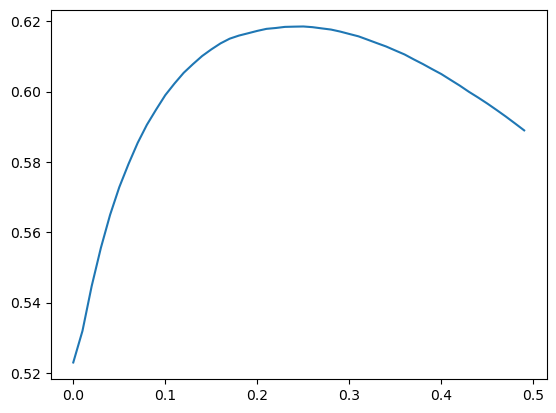

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,0.5,0.01), acc)
plt.show()

In [13]:
## evaludation functions

def get_ground_truth(test_output):

    ground_truths = [] 
    df = test_output
    df[['session_position','session_length']] = df[['session_position','session_length']].astype('int64')
    df = df[['session_id','skip_2','session_position','session_length']].loc[df['session_position']*2 > df['session_length']]
    df = df.reset_index()
    current_index = 0
    while current_index < len(df):
        partial_length = df['session_length'].iloc[current_index]-df['session_position'].iloc[current_index]+1
        session_skips = list(df.loc[current_index:current_index+partial_length-1, 'skip_2'])
        ground_truths.append(session_skips)
        current_index += partial_length 
    return ground_truths


def get_submission(test_output):
    submission = []
    for s in test_output['session_id'].unique():
        submission.append(np.array(test_output['pred'][test_output['session_id']==s]*1))
    return submission


def evaluate(submission,groundtruth):
    ap_sum = 0.0
    first_pred_acc_sum = 0.0
    counter = 0
    for sub, tru in zip(submission, groundtruth):
        if len(sub) != len(tru):
            raise Exception('Line {} should contain {} predictions, but instead contains '
                            '{}'.format(counter+1,len(tru),len(sub)))
        ap_sum += ave_pre(sub,tru,counter)
        first_pred_acc_sum += sub[0] == tru[0]
        counter+=1
    ap = ap_sum/counter
    first_pred_acc = first_pred_acc_sum/counter
    return ap,first_pred_acc


def ave_pre(submission,groundtruth,counter):
    s = 0.0
    t = 0.0
    c = 1.0
    for x, y in zip(submission, groundtruth):
        if x != 0 and x != 1:
            raise Exception('Invalid prediction in line {}, should be 0 or 1'.format(counter))
        if x==y:
            s += 1.0
            t += s / c
        c += 1
    return t/len(groundtruth)

def spotify_eval(y_true, y_pred, input_df):
    df_temp = input_df.loc[y_true.index.values,['session_id','skip_2','session_position','session_length']]
    df_temp['pred'] = y_pred
    ground_truths = get_ground_truth(df_temp)
    submission = get_submission(df_temp)
#     return ground_truths, submission
    ap,first_pred_acc = evaluate(submission,ground_truths)
    return ap,first_pred_acc

In [14]:
s_list = df_lookup['session_id'].unique()[0:2000]
sel_row = df_lookup['session_id'].isin(s_list)

In [15]:
ap,first_pred_acc  = spotify_eval(ytrue[sel_row], ypred[sel_row]>0.25, df_lookup.sort_values(['session_id','session_position']).loc[sel_row])

In [16]:
ap

0.510621004267447

In [17]:
first_pred_acc

0.705

In [18]:
df_lookup.sort_values(['session_id','session_position'])

,session_id,track_id_clean,skip_2,session_position,session_length,clus,skip_1_sk2True_mean,skip_2_sk2True_mean,skip_3_sk2True_mean,not_skipped_sk2True_mean,...,hist_user_behavior_reason_start_popup_sk2True_mean,hist_user_behavior_reason_start_clickside_sk2False_mean,hist_user_behavior_reason_end_uriopen_sk2False_mean,hist_user_behavior_reason_start_popup_sk2False_mean,hist_user_behavior_reason_end_clickside_sk2False_mean,hist_user_behavior_reason_start_uriopen_sk2True_mean,hist_user_behavior_reason_start_clickside_sk2True_mean,hist_user_behavior_reason_end_popup_sk2True_mean,hist_user_behavior_reason_end_clickside_sk2True_mean,hist_user_behavior_reason_end_popup_sk2False_mean
23227,34_0000e566-df12-4ef6-8b99-996d655db9bd,t_5baf3b3c-67a1-41ba-85cc-8cd14c32ac8e,False,6,10,76,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
16107,34_0000e566-df12-4ef6-8b99-996d655db9bd,t_9259ae1a-997c-490f-af04-346db442fb45,False,7,10,187,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
24710,34_0000e566-df12-4ef6-8b99-996d655db9bd,t_1a4d29a0-fa3d-4d6d-808c-a28b614a64b5,False,8,10,244,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2414,34_0000e566-df12-4ef6-8b99-996d655db9bd,t_ff674955-20ad-48bf-8494-d5fbe9dd7fac,False,9,10,66,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
55696,34_0000e566-df12-4ef6-8b99-996d655db9bd,t_eb5090e3-d0fb-4954-ac08-254a42e75fd1,False,10,10,185,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001907,34_ffff8bcd-8820-48e2-869a-f72ab75dd758,t_87b65963-79af-4a2c-8ba6-db50602e6110,False,7,11,233,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
982546,34_ffff8bcd-8820-48e2-869a-f72ab75dd758,t_6b7e0bcf-f1c4-4544-8133-fe3f2b33f58b,True,8,11,49,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9766,34_ffff8bcd-8820-48e2-869a-f72ab75dd758,t_6533717c-5c02-4c3c-8bd8-14f5140005cb,True,9,11,263,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9942,34_ffff8bcd-8820-48e2-869a-f72ab75dd758,t_d27f50dc-b883-4625-9696-76c65b5e6106,True,10,11,233,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
len(df_lookup['skip_2'][sel_row])

17043